<a href="https://colab.research.google.com/github/manuvillalba-uclm/Natural_Lenguaje_Processing-ELM/blob/main/Machine_Learning_NLP_Vectorization_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# dataframes library
!pip install pyspellchecker 
!pip install contractions
!pip install nltk --upgrade
!pip install emoji
import nltk
nltk.download("popular")
nltk.download('vader_lexicon') #sentiment analysis
nltk.download('twython') #twitter not necessary

Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.5)


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

False

In [2]:
import pandas as pd
import re


from nltk.tokenize.casual import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

#Correcciones y emoji
import emoji
from textblob import TextBlob
from spellchecker import SpellChecker
import contractions
from multiprocessing import Pool

#Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

#Feature selection 
from sklearn.feature_selection import SelectKBest, chi2

#Classification
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB

#Visualization and results
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from tabulate import tabulate
#knn
from sklearn import neighbors
from sklearn.model_selection import KFold
import numpy as np

In [3]:
raw_dataset_tweets = pd.read_csv('https://raw.githubusercontent.com/manuvillalba-uclm/Natural_Lenguaje_Processing-ELM/main/labeled_data.csv?token=AGI3DY5JJD5B6YDVPN6RALS73X4VW', index_col=[0])
ds_alt_twitter = pd.read_csv('https://raw.githubusercontent.com/manuvillalba-uclm/Natural_Lenguaje_Processing-ELM/main/preprocesado_hard.csv?token=ANLXPWJMEXACTZMMCGNJL6C74C6YU ', index_col=[0])
ds_alt_twitter = ds_alt_twitter.iloc[:,0]
ds_alt_twitter


0        ['trash', 'man', 'take', 'clean', 'hous', 'alw...
1        ['boy', 'dat', 'bad', 'place', 'coffin', 'hoe'...
2        ['dawg', 'confus', 'bitch', 'fuck', 'ever', 'c...
3                               ['tranni', 'like', 'look']
4        ['bitch', 'true', 'hear', 'told', 'faker', 'sh...
                               ...                        
24778    ['scriptur', 'trash', 'tl', 'right', 'lie', 'b...
24779    ['gone', 'redneck', 'babi', 'crazi', 'wrong', ...
24780    ['want', 'di', 'like', 'fuck', 'young', 'dat',...
24781              ['lie', 'bitch', 'tell', 'got', 'wild']
24782    ['coll', 'ruffl', 'tac', 'pink', 'yellow', 'or...
Name: tweet, Length: 24783, dtype: object

# Vectorization


In [4]:
def identity_tokenizer(text):
    return text

In [5]:
%%time
# TF-IDF
vectorizer = TfidfVectorizer(lowercase=False, max_features=10000, ngram_range=(1,4))    
vectors = vectorizer.fit_transform(ds_alt_twitter)

#We have to clean some variables, because we need storage in RAM later
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
vectors = None
denselist = dense.tolist()
dense = None
tweets_vectorization = pd.DataFrame(denselist, columns=feature_names)
denselist =None




CPU times: user 1min 15s, sys: 6.89 s, total: 1min 22s
Wall time: 1min 22s


In [6]:
tweets_vectorization

,a1,a3,aa,aaron,ab,abil,abl,abo,absolut,abu,abus,accent,accept,accid,accident,accord,account,accur,accus,ace,acid,acknowledg,across,act,act hate,act need,act nigga,act ya,actin,action,activ,actor,actress,actual,actual face,actual fuck,actual realli,actual trash,ad,adam,...,yo like,yo main,yo might,yo momma,yo new,yo nigga,yo polli,yo real,yo see,yo sometim,yo trna,yoga,yokel,york,york yanke,yosef,you,young,young bitch,young got,young nigga,young porn,young tear,younger,youth,youtub,yr,yu,yuan,yuh,yung,yup,zebra,zero,zimmerman,zip,zombi,zone,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.308487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Selection

In [7]:
class_label = raw_dataset_tweets.copy()
class_label = class_label['class']
class_label.reset_index(inplace = True, drop = True)

In [8]:
%%time

n_tweets = tweets_vectorization.shape[0]
n_features = tweets_vectorization.shape[1]
n_features = int(n_features*0.30)

class_label = class_label.iloc[0:n_tweets]

#quitamos el 70% de las features, se supone que en función del target class_label
tweets_vectorization = SelectKBest(chi2, k=n_features).fit_transform(tweets_vectorization,class_label)
tweets_vectorization

df_tweets_vectorization_selected = pd.DataFrame(data=tweets_vectorization)
df_tweets_vectorization_selected['target']= class_label

CPU times: user 2.25 s, sys: 215 ms, total: 2.46 s
Wall time: 1.83 s


# Let's try resampling our Dataset

In [9]:
df_tweets_vectorization_oversampling = df_tweets_vectorization_selected.copy()
df_tweets_vectorization_oversampling.groupby('target').count()
df_tweets_class0 = df_tweets_vectorization_oversampling.loc[df_tweets_vectorization_oversampling['target'] == 0]
df_tweets_class1 = df_tweets_vectorization_oversampling.loc[df_tweets_vectorization_oversampling['target'] == 1]
df_tweets_class2 = df_tweets_vectorization_oversampling.loc[df_tweets_vectorization_oversampling['target'] == 2]


In [10]:

df_tweets_vectorization_oversampling = df_tweets_vectorization_oversampling.append(df_tweets_class0)
df_tweets_vectorization_oversampling = df_tweets_vectorization_oversampling.append(df_tweets_class0)



In [11]:
df_tweets_vectorization_oversampling.reset_index(inplace=True, drop=True) 
df_tweets_vectorization_oversampling

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
27639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
27640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
27641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


# Classification

In [12]:
tweets_classification = df_tweets_vectorization_oversampling.copy()

In [13]:
model = BernoulliNB()

In [14]:
train, test = train_test_split(tweets_classification, test_size=0.30)
train.reset_index(inplace = True)
test.reset_index(inplace = True)
print(train.shape)
print(test.shape)

(19350, 3002)
(8293, 3002)


In [15]:
model.fit(train.loc[:, train.columns != 'target'], train['target'])
labels = model.predict(test.loc[:, test.columns != 'target'])

# Evaluation

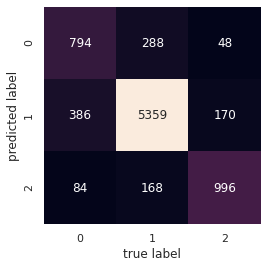

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
mat = confusion_matrix(test['target'], labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [17]:

precision, recall, fscore, support = score(test['target'], labels)
print(tabulate({'Name': ['hate speech', 'offensive lenguage', 'neither'], 'Class': [0,1,2],'Precision':precision, 'Recall': recall, 'F-Score': fscore, 'Support': support} , headers=['Name','Class','Precision', 'Recall','F-Score','Support'], tablefmt='orgtbl'))

| Name               |   Class |   Precision |   Recall |   F-Score |   Support |
|--------------------+---------+-------------+----------+-----------+-----------|
| hate speech        |       0 |    0.702655 | 0.628165 |  0.663325 |      1264 |
| offensive lenguage |       1 |    0.906002 | 0.921582 |  0.913725 |      5815 |
| neither            |       2 |    0.798077 | 0.820428 |  0.809098 |      1214 |


We know that accuracy is not a correct metric to evaluate these types of problems, but we are just curious

In [18]:
acc = accuracy_score(test['target'], labels)
print ('Acc', acc)

Acc 0.8620523332931388


# Random Forest

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

train_rf, test_rf = train_test_split(tweets_classification, test_size=0.30)
train_rf.reset_index(inplace = True)
test_rf.reset_index(inplace = True)


In [34]:
%%time
model = RandomForestClassifier(n_estimators=1000, max_features="sqrt")
model.fit(train_rf.loc[:, train.columns != 'target'], train_rf['target'])
ypred = model.predict(test_rf.loc[:, train.columns != 'target'])

CPU times: user 6min 1s, sys: 124 ms, total: 6min 1s
Wall time: 6min 1s


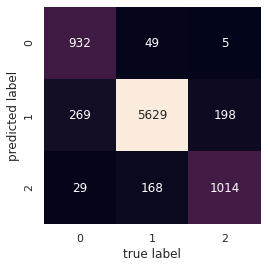

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
mat = confusion_matrix(test_rf['target'], ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [36]:
precision, recall, fscore, support = score(test_rf['target'], ypred)
print(tabulate({'Name': ['hate speech', 'offensive lenguage', 'neither'], 'Class': [0,1,2],'Precision':precision, 'Recall': recall, 'F-Score': fscore, 'Support': support} , headers=['Name','Class','Precision', 'Recall','F-Score','Support'], tablefmt='orgtbl'))

| Name               |   Class |   Precision |   Recall |   F-Score |   Support |
|--------------------+---------+-------------+----------+-----------+-----------|
| hate speech        |       0 |    0.945233 | 0.757724 |  0.841155 |      1230 |
| offensive lenguage |       1 |    0.923392 | 0.962881 |  0.942723 |      5846 |
| neither            |       2 |    0.837325 | 0.833196 |  0.835255 |      1217 |


In [37]:
acc = accuracy_score(test_rf['target'], ypred)
print ('Acc', acc)

Acc 0.9134209574339804


# Prueba con Knn

In [22]:
"""
train_knn, test_knn = train_test_split(tweets_classification, test_size=0.30)
train_knn.reset_index(inplace = True)
test_knn.reset_index(inplace = True)
print(train_knn.shape)
print(test_knn.shape)
"""

'\ntrain_knn, test_knn = train_test_split(tweets_classification, test_size=0.30)\ntrain_knn.reset_index(inplace = True)\ntest_knn.reset_index(inplace = True)\nprint(train_knn.shape)\nprint(test_knn.shape)\n'

In [23]:
"""
%%time 

cv = KFold(n_splits = 2, shuffle = True) # shuffle = False si hay dimensión temporal 

for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_score= []
       knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
       for train_fold, test_fold in cv.split(train_knn):
          # División train test aleatoria
          f_train = train_knn.loc[train_fold]
          f_test = train_knn.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(['target'], axis=1), 
                               y = f_train['target'])
          y_pred = knn.predict(X = f_test.drop(['target'], axis = 1))
          # evaluación del modelo
          precision, recall, fscore, support = score(f_test['target'], y_pred)
          
          fold_score.append(sum(fscore)/3)
       total_scores.append(sum(fold_score)/len(fold_score))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
   plt.ylabel('Precision/Recall')      
    

plt.legend()
plt.show() 
"""

'\n%%time \n\ncv = KFold(n_splits = 2, shuffle = True) # shuffle = False si hay dimensión temporal \n\nfor i, weights in enumerate([\'uniform\', \'distance\']):\n   total_scores = []\n   for n_neighbors in range(1,30):\n       fold_score= []\n       knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)\n       for train_fold, test_fold in cv.split(train_knn):\n          # División train test aleatoria\n          f_train = train_knn.loc[train_fold]\n          f_test = train_knn.loc[test_fold]\n          # entrenamiento y ejecución del modelo\n          knn.fit( X = f_train.drop([\'target\'], axis=1), \n                               y = f_train[\'target\'])\n          y_pred = knn.predict(X = f_test.drop([\'target\'], axis = 1))\n          # evaluación del modelo\n          precision, recall, fscore, support = score(f_test[\'target\'], y_pred)\n          \n          fold_score.append(sum(fscore)/3)\n       total_scores.append(sum(fold_score)/len(fold_score))\n   \n   plt.pl

In [24]:
"""
n_neighbors = 19
weights = 'uniform'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights) 
# fit and predict
knn.fit(X = train_knn.loc[:, train_knn.columns != 'target'], y = train_knn['target'])
y_pred = knn.predict(X = test.loc[:, test_knn.columns != 'target'])
precision, recall, fscore, support = score(test_knn['target'], y_pred)
print(tabulate({'Name': ['hate speech', 'offensive lenguage', 'neither'], 'Class': [0,1,2],'Precision':precision, 'Recall': recall, 'F-Score': fscore, 'Support': support} , headers=['Name','Class','Precision', 'Recall','F-Score','Support'], tablefmt='orgtbl'))

"""

"\nn_neighbors = 19\nweights = 'uniform'\nknn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights) \n# fit and predict\nknn.fit(X = train_knn.loc[:, train_knn.columns != 'target'], y = train_knn['target'])\ny_pred = knn.predict(X = test.loc[:, test_knn.columns != 'target'])\nprecision, recall, fscore, support = score(test_knn['target'], y_pred)\nprint(tabulate({'Name': ['hate speech', 'offensive lenguage', 'neither'], 'Class': [0,1,2],'Precision':precision, 'Recall': recall, 'F-Score': fscore, 'Support': support} , headers=['Name','Class','Precision', 'Recall','F-Score','Support'], tablefmt='orgtbl'))\n\n"